11490434/11490434 [==============================] - 1s 0us/step
Edge server 1 has 5 unique labels: [0 1 2 3 4]
Count of each label: {0: 1200, 1: 1200, 2: 1200, 3: 1200, 4: 1200}
Edge server 2 has 5 unique labels: [5 6 7 8 9]
Count of each label: {5: 1200, 6: 1200, 7: 1200, 8: 1200, 9: 1200}
Edge server 3 has 5 unique labels: [0 1 2 3 4]
Count of each label: {0: 1200, 1: 1200, 2: 1200, 3: 1200, 4: 1200}
Edge server 4 has 5 unique labels: [5 6 7 8 9]
Count of each label: {5: 1200, 6: 1200, 7: 1200, 8: 1200, 9: 1200}
Edge server 5 has 5 unique labels: [0 1 2 3 4]
Count of each label: {0: 1200, 1: 1200, 2: 1200, 3: 1200, 4: 1200}
After Edge Aggregation 1 in round 1: Test Loss = 2.9274630546569824, Test Accuracy = 0.2280000001192093
After Edge Aggregation 2 in round 1: Test Loss = 2.7989425659179688, Test Accuracy = 0.13979999721050262
After Edge Aggregation 3 in round 1: Test Loss = 2.9339120388031006, Test Accuracy = 0.22789999842643738
After Edge Aggregation 4 in round 1: Test Loss = 2.

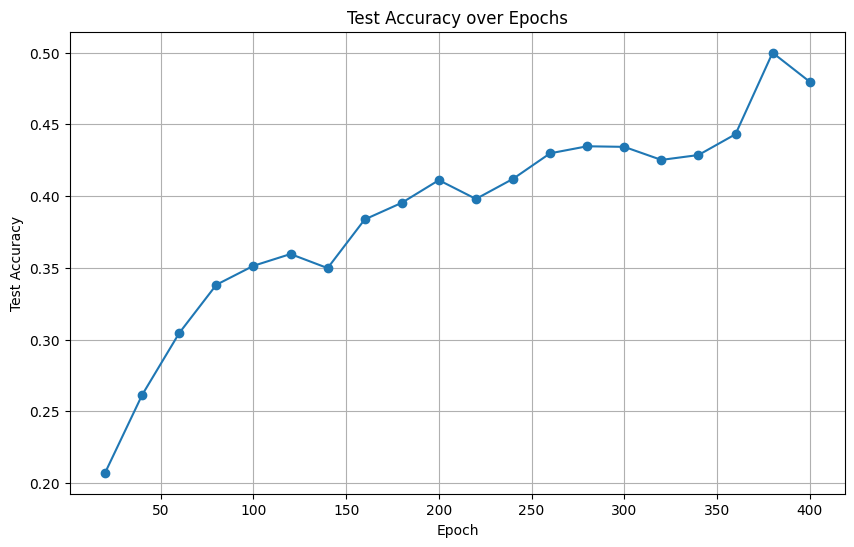

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# MNIST 데이터셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 0~255의 픽셀값을 0~1 사이 실수로 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# CNN을 위해 입력 데이터 형태 변경
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# MNIST 손글씨 숫자를 분류하는 CNN 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='he_uniform')
])

num_clients = 50
num_edges = num_clients // 10
B = 20

num_labels = 10
total_sample = 600  # 클라이언트 당 데이터를 600개로 수정

client_indices_list = []
label_indices = [[] for _ in range(num_labels)]

for i in range(len(y_train)):
    label = y_train[i]
    label_indices[label].append(i)

for i in range(num_edges):
    selected_labels = np.arange(i * 5, (i + 1) * 5) % num_labels
    for j in range(10):
        selected_label = selected_labels[j // 2]
        label_samples = label_indices[selected_label]
        selected_samples = np.random.choice(label_samples, total_sample, replace=False)
        client_indices_list.append(np.array(selected_samples))

# After data partitioning
for edge_idx in range(num_edges):
    edge_labels = []
    for client_idx in range(edge_idx * (num_clients // num_edges), (edge_idx+1) * (num_clients // num_edges)):
        edge_labels.extend(y_train[client_indices_list[client_idx]])
    unique_labels, label_counts = np.unique(edge_labels, return_counts=True)
    print(f"Edge server {edge_idx+1} has {len(unique_labels)} unique labels: {unique_labels}")
    print(f"Count of each label: {dict(zip(unique_labels, label_counts))}")

edge_models = [model.get_weights()] * num_edges

def client_update(client_x, client_y, B, E):
    sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.01 * 0.995 ** epoch)

    model.compile(optimizer=sgd,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(client_x,
                        client_y,
                        batch_size=B,
                        epochs=E,
                        callbacks=[lr_schedule],
                        shuffle=True,
                        verbose=0)

    return model.get_weights()  # Return the updated weights

num_rounds = 20
E = 20

w = model.get_weights()

rounds_list = []
test_acc_list = []

k1, k2 = 1, 1
local_update_counter = 0
edge_update_counter = 0

for t in range(num_rounds):
    edge_updates = [None] * num_edges
    for edge_idx in range(num_edges):
        client_updates = []
        client_sizes = []
        for client_idx in range(edge_idx * 10, (edge_idx + 1) * 10):  # Each edge has 10 clients
            model.set_weights(edge_models[edge_idx])

            client_x = x_train[client_indices_list[client_idx]]
            client_y = y_train[client_indices_list[client_idx]]

            updated_weights = client_update(client_x, client_y, B, E)

            client_updates.append(updated_weights)
            client_sizes.append(len(client_x))

        # Aggregate the updates from the clients of this edge using weighted average
        total_size = sum(client_sizes)
        weights = [size / total_size for size in client_sizes]
        edge_updates[edge_idx] = [np.average([update[i] for update in client_updates], axis=0, weights=weights) for i in range(len(w))]

        # Set the edge model weights to the edge updates
        edge_models[edge_idx] = edge_updates[edge_idx]

    local_update_counter += 1

    if local_update_counter % k1 == 0:
        # Evaluate the model with the test dataset for each edge
        for edge_idx in range(num_edges):
            model.set_weights(edge_models[edge_idx])
            test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
            print(f"After Edge Aggregation {edge_idx+1} in round {t+1}: Test Loss = {test_loss}, Test Accuracy = {test_acc}")

        edge_update_counter += 1

        if edge_update_counter % k2 == 0 and None not in edge_updates:
            # Aggregate the updates from all the edges
            averaged_weights = [np.mean([update[i] for update in edge_updates if update is not None], axis=0) for i in range(len(w))]

            model.set_weights(averaged_weights)

            test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

            print(f"After Cloud Aggregation in round {t+1}: Test Loss = {test_loss}, Test Accuracy = {test_acc}")

            rounds_list.append((t + 1) * E)  # Multiply t+1 by E for epoch-based x-axis
            test_acc_list.append(test_acc)

plt.figure(figsize=(10, 6))
plt.plot(rounds_list, test_acc_list, marker='o')
plt.title("Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()